In [1]:
import numpy as np
import sklearn as sk
from sklearn import mixture, cluster,metrics, neural_network

In [2]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
import json 

with open('./data/train.jsonl', 'r') as json_file:
    json_list = list(json_file)
  
text_list = list() # storing in lists
id_list = list()
labels_list = list()

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")

with open('./data/test_seen.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")

In [4]:
import pandas as pd 
df = pd.DataFrame({"id": id_list, "text": text_list}) #converting into dataframes

df_label = pd.DataFrame({"id": id_list, "label": labels_list})

df_label_sort = df_label.sort_values(by="id")


labels_true = df_label_sort["label"].to_numpy().astype(int)
print(labels_true)

[1 0 0 ... 1 0 0]


In [5]:
df.to_csv("caption_initial.csv") # saving in CSV

In [6]:
tokenized_list = list()

for i in df['text']:
  i = "[CLS] " + i + " [SEP]"
  tokenized_text = tokenizer.tokenize(i)
  tokenized_list.append(tokenized_text)

indexed_list = list()

for i in tokenized_list:
  indexed_list.append(tokenizer.convert_tokens_to_ids(i))

In [7]:
segment_list = list()

for i in tokenized_list:
  segment_list.append([1] * len(i))

In [8]:
# Convert inputs to PyTorch tensors

tokens_tensor_list = list()
segments_tensor_list = list()

for i in indexed_list:
  tokens_tensor_list.append(torch.tensor([i]))

for i in segment_list:
  segments_tensor_list.append(torch.tensor([i]))

In [9]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
outputs_list = list()
hidden_states_list = list() 
with torch.no_grad():
  for (i,j) in zip(tokens_tensor_list,segments_tensor_list):
      outputs = model(i,j)
      outputs_list.append(outputs)
      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states_list.append(outputs[2])

In [12]:
import pickle as p
file_name = "data/010_fc.pkl"
with open(file_name, 'rb') as f:
    data_image_in = p.load(f)

In [14]:
data_text_list= []
for layer in range(13):
    sentence_embedding_list = list()
    for i in hidden_states_list:
        token_vecs = i[layer-1][0][:][:]
        sentence_embedding_list.append(torch.mean(token_vecs, dim=0))
    df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list})
    df2 = df2.sort_values(by = "id", ascending = True)
    data_text_list.append(torch.cat(df2["features"].tolist()).numpy().reshape(9500,768))

In [15]:
data_text = torch.cat(df2["features"].tolist()).numpy().reshape(9500,768)
data_image = data_image_in.to_numpy()[0:9500,1:]

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, schedules

In [17]:
def skip_model(input_size):
    inp = tf.keras.Input(input_size,)
    
    dense1 = Dense(256)(inp)
    act1 = LeakyReLU(0.1)(dense1)
    drop1 = Dropout(0.5)(act1)
    
    dense2 = Dense(256)(drop1)
    act2 = LeakyReLU(0.1)(dense2)
    drop2 = Dropout(0.5)(act2)
    
    skip1 = Add()([drop1, drop2])
    
    dense3 = Dense(256)(skip1)
    act3 = LeakyReLU(0.1)(dense3)
    drop3 = Dropout(0.5)(act3)
    
    skip2 = Add()([drop1, drop3])
    
    dense4 = Dense(256)(skip2)
    act4 = LeakyReLU(0.1)(dense4)
    drop4 = Dropout(0.5)(act4)
    
    skip3 = Add()([drop1, drop4])
    
    dense5 = Dense(256)(skip3)
    act5 = LeakyReLU(0.1)(dense5)
    drop5 = Dropout(0.5)(act5)
    
    skip4 = Add()([drop1, drop5])
    
    dense6 = Dense(256)(skip4)
    act6 = LeakyReLU(0.1)(dense6)
    drop6 = Dropout(0.5)(act6)
    
    skip5 = Add()([drop1, drop6])
    
    dense6 = Dense(256)(skip4)
    act6 = LeakyReLU(0.1)(dense6)
    
    out = Dense(1, activation='sigmoid')(act6)
    
    model = Model(inputs = inp, outputs = out)
    
    return model

In [18]:
num_models = 10
num_feat = 3

test_out_prob = []
hist = []
for i in range(num_models):
    feautre_idx = np.random.choice(np.arange(13), size = num_feat)
    print(feautre_idx)
    data_concat = data_text_list[feautre_idx[0]]
    for i in range(num_feat-1):
        data_concat = np.concatenate((data_concat,data_text_list[feautre_idx[i+1]]), axis = 1)
    data_reduced = np.concatenate((data_image,data_concat),axis = 1)
    data_normalized = (data_reduced-np.mean(data_reduced, axis = 0))/(np.var(data_reduced, axis = 0)**0.5+1e-3)
    
    x_train = data_normalized[0:8500,:]
    y_train = labels_true[0:8500]

    x_val = data_normalized[8500:9500,:]
    y_val = labels_true[8500:9500]
    input_size = data_normalized.shape[1]
    model = skip_model(input_size)
    
    metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=4,verbose=1,mode="auto",baseline=None,restore_best_weights=False)
    
    model.compile(optimizer=SGD(learning_rate=0.005), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

    print("Fit model on training data")
    history = model.fit(x_train,y_train,batch_size=32,epochs=30,validation_data=(x_val, y_val), callbacks=[callback])
    hist.append(history)
    test_out_prob.append(model(x_val))



[1 0 2]
Fit model on training data
Epoch 1/30
266/266 [==============================] - 29s 105ms/step - loss: 0.8186 - binary_accuracy: 0.5945 - auc: 0.5686 - precision: 0.4363 - recall: 0.3568 - val_loss: 0.6901 - val_binary_accuracy: 0.5610 - val_auc: 0.7014 - val_precision: 0.4635 - val_recall: 0.8527
Epoch 2/30
266/266 [==============================] - 28s 107ms/step - loss: 0.6759 - binary_accuracy: 0.6278 - auc: 0.6194 - precision: 0.4907 - recall: 0.3536 - val_loss: 0.6060 - val_binary_accuracy: 0.6900 - val_auc: 0.7185 - val_precision: 0.6262 - val_recall: 0.4935
Epoch 3/30
266/266 [==============================] - 27s 102ms/step - loss: 0.6411 - binary_accuracy: 0.6472 - auc: 0.6523 - precision: 0.5283 - recall: 0.3680 - val_loss: 0.5990 - val_binary_accuracy: 0.6910 - val_auc: 0.7318 - val_precision: 0.6275 - val_recall: 0.4961
Epoch 4/30
266/266 [==============================] - 28s 106ms/step - loss: 0.6176 - binary_accuracy: 0.6648 - auc: 0.6821 - precision: 0.5638 - 

266/266 [==============================] - 28s 105ms/step - loss: 0.5427 - binary_accuracy: 0.7278 - auc_1: 0.7737 - precision_1: 0.6630 - recall_1: 0.5263 - val_loss: 0.5792 - val_binary_accuracy: 0.7010 - val_auc_1: 0.7459 - val_precision_1: 0.6164 - val_recall_1: 0.6021
Epoch 13/30
266/266 [==============================] - 27s 100ms/step - loss: 0.5336 - binary_accuracy: 0.7285 - auc_1: 0.7814 - precision_1: 0.6648 - recall_1: 0.5259 - val_loss: 0.5846 - val_binary_accuracy: 0.7010 - val_auc_1: 0.7489 - val_precision_1: 0.6033 - val_recall_1: 0.6641
Epoch 13: early stopping
[2 1 4]
Fit model on training data
Epoch 1/30
266/266 [==============================] - 28s 103ms/step - loss: 0.8319 - binary_accuracy: 0.5786 - auc_2: 0.5490 - precision_2: 0.4095 - recall_2: 0.3334 - val_loss: 0.6513 - val_binary_accuracy: 0.6100 - val_auc_2: 0.6562 - val_precision_2: 0.4967 - val_recall_2: 0.5762
Epoch 2/30
266/266 [==============================] - 26s 99ms/step - loss: 0.6829 - binary_acc

266/266 [==============================] - 26s 98ms/step - loss: 0.6422 - binary_accuracy: 0.6468 - auc_3: 0.6463 - precision_3: 0.5285 - recall_3: 0.3568 - val_loss: 0.6044 - val_binary_accuracy: 0.6810 - val_auc_3: 0.7053 - val_precision_3: 0.6848 - val_recall_3: 0.3256
Epoch 4/30
266/266 [==============================] - 28s 106ms/step - loss: 0.6162 - binary_accuracy: 0.6689 - auc_3: 0.6794 - precision_3: 0.5752 - recall_3: 0.3773 - val_loss: 0.5958 - val_binary_accuracy: 0.6900 - val_auc_3: 0.7162 - val_precision_3: 0.6370 - val_recall_3: 0.4625
Epoch 5/30
266/266 [==============================] - 26s 98ms/step - loss: 0.6072 - binary_accuracy: 0.6801 - auc_3: 0.6950 - precision_3: 0.5932 - recall_3: 0.4110 - val_loss: 0.5919 - val_binary_accuracy: 0.6930 - val_auc_3: 0.7237 - val_precision_3: 0.6527 - val_recall_3: 0.4419
Epoch 6/30
266/266 [==============================] - 26s 99ms/step - loss: 0.5957 - binary_accuracy: 0.6864 - auc_3: 0.7082 - precision_3: 0.6051 - recall_3:

Epoch 17/30
266/266 [==============================] - 26s 98ms/step - loss: 0.5278 - binary_accuracy: 0.7345 - auc_4: 0.7898 - precision_4: 0.6779 - recall_4: 0.5279 - val_loss: 0.5846 - val_binary_accuracy: 0.6970 - val_auc_4: 0.7449 - val_precision_4: 0.6055 - val_recall_4: 0.6227
Epoch 18/30
266/266 [==============================] - 26s 97ms/step - loss: 0.5194 - binary_accuracy: 0.7474 - auc_4: 0.7962 - precision_4: 0.6937 - recall_4: 0.5593 - val_loss: 0.5811 - val_binary_accuracy: 0.7010 - val_auc_4: 0.7455 - val_precision_4: 0.6170 - val_recall_4: 0.5995
Epoch 18: early stopping
[ 6  8 12]
Fit model on training data
Epoch 1/30
266/266 [==============================] - 27s 97ms/step - loss: 0.8117 - binary_accuracy: 0.5907 - auc_5: 0.5638 - precision_5: 0.4284 - recall_5: 0.3421 - val_loss: 0.6202 - val_binary_accuracy: 0.6550 - val_auc_5: 0.6815 - val_precision_5: 0.6129 - val_recall_5: 0.2946
Epoch 2/30
266/266 [==============================] - 26s 97ms/step - loss: 0.6696 

266/266 [==============================] - 26s 96ms/step - loss: 0.6422 - binary_accuracy: 0.6416 - auc_6: 0.6510 - precision_6: 0.5171 - recall_6: 0.3674 - val_loss: 0.6070 - val_binary_accuracy: 0.6770 - val_auc_6: 0.6961 - val_precision_6: 0.6203 - val_recall_6: 0.4264
Epoch 4/30
266/266 [==============================] - 26s 97ms/step - loss: 0.6205 - binary_accuracy: 0.6668 - auc_6: 0.6803 - precision_6: 0.5677 - recall_6: 0.3895 - val_loss: 0.5995 - val_binary_accuracy: 0.6840 - val_auc_6: 0.7075 - val_precision_6: 0.6524 - val_recall_6: 0.3928
Epoch 5/30
266/266 [==============================] - 25s 96ms/step - loss: 0.6102 - binary_accuracy: 0.6741 - auc_6: 0.6891 - precision_6: 0.5807 - recall_6: 0.4055 - val_loss: 0.6046 - val_binary_accuracy: 0.6550 - val_auc_6: 0.7183 - val_precision_6: 0.5547 - val_recall_6: 0.5504
Epoch 6/30
266/266 [==============================] - 25s 96ms/step - loss: 0.5942 - binary_accuracy: 0.6865 - auc_6: 0.7092 - precision_6: 0.6072 - recall_6: 

Epoch 21/30
266/266 [==============================] - 27s 101ms/step - loss: 0.4884 - binary_accuracy: 0.7645 - auc_7: 0.8246 - precision_7: 0.7174 - recall_7: 0.5919 - val_loss: 0.5633 - val_binary_accuracy: 0.7120 - val_auc_7: 0.7637 - val_precision_7: 0.6443 - val_recall_7: 0.5711
Epoch 22/30
266/266 [==============================] - 26s 100ms/step - loss: 0.4875 - binary_accuracy: 0.7659 - auc_7: 0.8262 - precision_7: 0.7165 - recall_7: 0.5999 - val_loss: 0.5664 - val_binary_accuracy: 0.7150 - val_auc_7: 0.7636 - val_precision_7: 0.6342 - val_recall_7: 0.6227
Epoch 23/30
266/266 [==============================] - 26s 99ms/step - loss: 0.4799 - binary_accuracy: 0.7694 - auc_7: 0.8322 - precision_7: 0.7209 - recall_7: 0.6073 - val_loss: 0.5664 - val_binary_accuracy: 0.7140 - val_auc_7: 0.7632 - val_precision_7: 0.6407 - val_recall_7: 0.5943
Epoch 24/30
266/266 [==============================] - 26s 100ms/step - loss: 0.4735 - binary_accuracy: 0.7718 - auc_7: 0.8369 - precision_7: 0

266/266 [==============================] - 26s 97ms/step - loss: 0.5798 - binary_accuracy: 0.6986 - auc_9: 0.7279 - precision_9: 0.6211 - recall_9: 0.4600 - val_loss: 0.5889 - val_binary_accuracy: 0.6920 - val_auc_9: 0.7299 - val_precision_9: 0.6138 - val_recall_9: 0.5504
Epoch 8/30
266/266 [==============================] - 27s 102ms/step - loss: 0.5662 - binary_accuracy: 0.7087 - auc_9: 0.7459 - precision_9: 0.6410 - recall_9: 0.4702 - val_loss: 0.5904 - val_binary_accuracy: 0.6850 - val_auc_9: 0.7341 - val_precision_9: 0.5918 - val_recall_9: 0.5995
Epoch 9/30
266/266 [==============================] - 29s 109ms/step - loss: 0.5673 - binary_accuracy: 0.7104 - auc_9: 0.7444 - precision_9: 0.6416 - recall_9: 0.4789 - val_loss: 0.5819 - val_binary_accuracy: 0.6860 - val_auc_9: 0.7363 - val_precision_9: 0.6090 - val_recall_9: 0.5271
Epoch 10/30
266/266 [==============================] - 25s 95ms/step - loss: 0.5537 - binary_accuracy: 0.7164 - auc_9: 0.7602 - precision_9: 0.6525 - recall_

In [20]:
from sklearn import metrics
test_out_prob_array = np.array(test_out_prob)
final_out = np.mean(test_out_prob, axis = 0)
final_score = metrics.roc_auc_score(y_val, final_out)
print("Val AUROC1 Score",final_score)

final_score = metrics.accuracy_score(y_val, np.rint(final_out))
print("Val Accuracy1",final_score)

final_out = np.mean(np.rint(test_out_prob), axis = 0)
final_score = metrics.roc_auc_score(y_val, final_out)
print("Val AUROC2 Score",final_score)

final_score = metrics.accuracy_score(y_val, np.rint(final_out))
print("Val Accuracy2",final_score)

Val AUROC1 Score 0.7624888821444078
Val Accuracy1 0.708
Val AUROC2 Score 0.7426853994629707
Val Accuracy2 0.717


In [34]:
with open('history.pkl', 'wb') as handle:
    p.dump(hist, handle, protocol=p.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://b42fb825-08a8-4b3a-965d-70648a2a5e53/assets
INFO:tensorflow:Assets written to: ram://1adaa367-e198-4128-bc86-cd8b60f39fc2/assets
INFO:tensorflow:Assets written to: ram://72d5fc9a-2902-4843-a6a5-b65f0c7ca3b3/assets
INFO:tensorflow:Assets written to: ram://10f02f6d-e6b8-4b77-959f-49639ea56f3d/assets
INFO:tensorflow:Assets written to: ram://123651c7-4971-4a16-990e-4e8e60599986/assets
INFO:tensorflow:Assets written to: ram://2de99f6d-0e75-4d0c-b2c0-505f5537cab3/assets
INFO:tensorflow:Assets written to: ram://ae37a2aa-6855-40f3-b18d-a4dfc493f1bd/assets
INFO:tensorflow:Assets written to: ram://8557a4e7-afb6-47cc-a170-aab13035459f/assets
INFO:tensorflow:Assets written to: ram://8b6a4b83-4ea3-4d9a-a68f-64b5d37c6fe9/assets
INFO:tensorflow:Assets written to: ram://39b3c030-8e32-43eb-bdd2-6e5e53761c74/assets


C:\Users\jsharda3\Miniconda3\envs\ML_project\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


AttributeError: module 'numpy' has no attribute 'squeze'

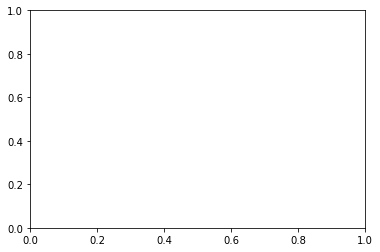

In [61]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

z = TSNE(n_components=2, learning_rate='auto',init='pca',n_iter=10000).fit_transform(x_val)
fig, ax = plt.subplots()
final_error = y_val+np.squeeze(np.rint(final_out))

color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]
for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1],np.abs(y_val-np.squeeze(final_out)), c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()

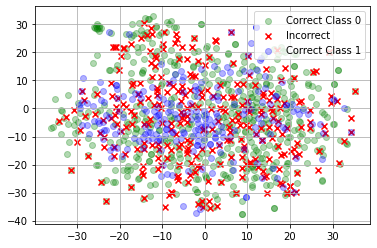

In [75]:
fig, ax = plt.subplots()
color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]

for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1], c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()
fig.savefig("resnet_bert_bagging.jpg")

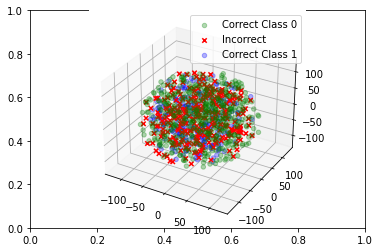

In [60]:
color = ["green","red","blue"]
label = ["Correct Class 0","Incorrect","Correct Class 1"]
marker = ["o","x","o"]
alpha = [0.3,1,0.3]
fig, ax = plt.subplots()
ax = fig.add_subplot(projection='3d')
for i in range(3):
    ax.scatter(z[final_error==i,0],z[final_error==i,1],z[final_error==i,2], c=color[i], label = label[i],marker=marker[i], alpha = alpha[i])
ax.legend()
ax.grid(True)

plt.show()